# 前処理

## アノテーションデータの整形

In [1]:
import numpy as np
import pandas as pd

In [2]:
# data/は空なのでこのコードは走らない
df_j = pd.read_csv("data/Thai_adults_tournament＿refined.csv").set_index("order_no/id")
subj_idx_j = df_j.columns.to_list()
language_j = ["Japanese" for _ in subj_idx_j]
strokes_j = [" ".join(row) for row in df_j.to_numpy().T.astype(str)]

# len(subject_idx)
df_t = pd.read_csv("data/28_tournament.csv").set_index("order_no/id")
subj_idx_t = df_t.columns.to_list()
language_t = ["Thai" for _ in subj_idx_t]
strokes_t = [" ".join(row) for row in df_t.to_numpy().T.astype(str)]

In [3]:
df = pd.DataFrame({
    "subj_idx": subj_idx_j+subj_idx_t,
    "language": language_j+language_t,
    "strokes": strokes_j+strokes_t,
})
df

,subj_idx,language,strokes
0,adults-1,Japanese,rank3 rank2_1 rank2_1 rank2_2 rank2_2 rank2_2 ...
1,adults-2,Japanese,rank1_1 rank1_1 rank1_2 rank1_2 rank2_1 rank2_...
2,adults-3,Japanese,rank3 rank2_1 rank2_1 rank1_1 rank1_2 rank2_2 ...
3,adults-4,Japanese,rank1_1 rank1_2 rank2_1 rank1_3 rank1_4 rank2_...
4,adults-5,Japanese,rank3 rank2_1 rank2_2 rank1_1 rank1_2 rank1_3 ...
...,...,...,...
66,DA19s-32,Thai,rank3 rank3 rank2_1 rank2_1 rank1_1 rank1_1 ra...
67,DA19s-33,Thai,rank3 rank3 rank2_1 rank2_1 rank1_1 rank1_1 ra...
68,DA19s-34,Thai,rank1_1 rank1_1 rank1_2 rank1_2 rank1_3 rank1_...
69,DA19s-35,Thai,rank3 rank3 rank2_2 rank2_2 rank1_4 rank1_4 ra...


In [4]:
len(set(" ".join(df.strokes).split())) - 1

11

## テキスト特徴量の抽出

In [5]:
from sklearn.feature_extraction.text \
    import CountVectorizer

In [6]:
n_gram = 2

vectorizer = CountVectorizer(
    stop_words=["nan", "extra", "point"],
    ngram_range=(1, n_gram),
)
corpus = df.strokes
vectorizer.fit(corpus)

CountVectorizer(ngram_range=(1, 2), stop_words=['nan', 'extra', 'point'])

In [7]:
X = vectorizer.transform(corpus).toarray()
cols = vectorizer.get_feature_names_out()
cols = list(map(lambda s: s.replace(" ", "-"), cols))
df_bow = pd.DataFrame(X, columns=cols)

In [8]:
y = df.language == "Japanese"
y = y.astype(int)
y

0     1
1     1
2     1
3     1
4     1
     ..
66    0
67    0
68    0
69    0
70    0
Name: language, Length: 71, dtype: int64

## 可視化と解釈

In [9]:
from sklearn.linear_model \
    import LogisticRegression

In [10]:
C = 1
lr_l1 = LogisticRegression(C=C,
                           penalty='l1',
                           solver='liblinear')
lr_l1.fit(X, y)  # estimate Beta
coef = lr_l1.coef_.flatten()
non_zero = coef != 0
sum(non_zero)

9

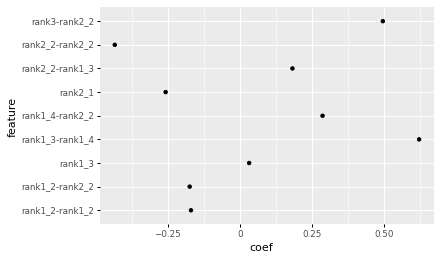

/srv/conda/envs/notebook/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 7.0 x 7.0 cm image.
/srv/conda/envs/notebook/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: coef_1.pdf


In [11]:
from plotnine import *

res = pd.DataFrame(
    {"coef": coef[non_zero],
     "feature":np.array(cols)[non_zero]})
p = (ggplot(res, aes(x='coef', y='feature'))
     + geom_point()
     )
print(p)
p.save(f'coef_{C}.pdf', height=7, width=7, units="cm")